In [1]:

import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from scipy import ndimage





def load_image(filename, as_gray=False, as_float=False):
    if as_gray:
        a = np.asarray(Image.open(filename).convert('L'))
    else:
        a = np.asarray(Image.open(filename))
    if as_float:
        return a.astype(np.float) / 255
    else:
        return a

def display_image(im, as_gray=False, title=None):
    plt.figure(figsize=(9,4))
    if as_gray:
        plt.imshow(im, cmap='gray')
    else:
        plt.imshow(im)
    if title is not None:
        plt.title(title)

def display_vec(v, title=None):
    plt.figure(figsize=(9,4))
    plt.plot(v)
    if title is not None:
        plt.title(title)
        



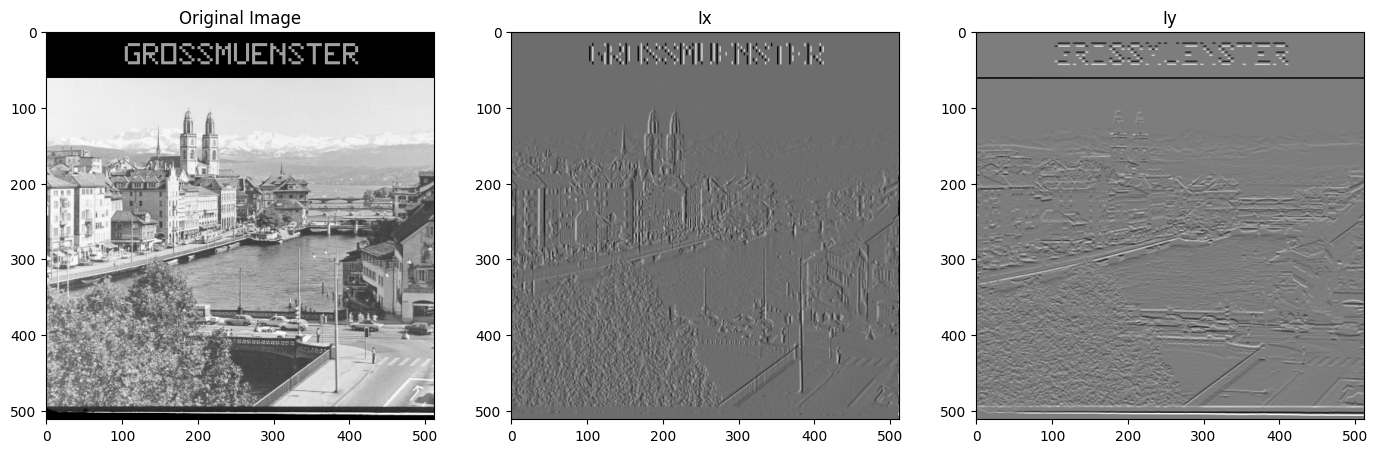

In [30]:


from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import convolve
from scipy.signal import convolve2d


I = load_image('zurlim.png', as_gray=True, as_float=False)

#step 1 smoothing of the image

kernel_size = 5
sigma = 1.0

kernel = np.fromfunction(
    lambda x, y: (1/ (2 * np.pi * sigma**2)) *
                  np.exp(-((x - (kernel_size - 1) / 2)**2 + (y - (kernel_size - 1) / 2)**2) / (2 * sigma**2)),
    (kernel_size, kernel_size)
)
kernel /= np.sum(kernel)
Gaussien_filter_6 = convolve2d(I, kernel, mode='same', boundary='wrap')


# defining Ix and Iy
vertical_sobel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=float)
horizontal_sobel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=float)

Ix = convolve2d(I, vertical_sobel, mode='same', boundary='wrap')
Iy = convolve2d(I, horizontal_sobel, mode='same', boundary='wrap')

# approximating the gradient Magnitude

gradient_magnitude = np.sqrt(np.square(Ix) + np.square(Iy))
gradient_magnitude *= 255.0 / gradient_magnitude.max()



Ix2 = convolve2d(Ix, vertical_sobel, mode='same', boundary='wrap')
Iy2 = convolve2d(Iy, horizontal_sobel, mode='same', boundary='wrap')
Ixy = convolve2d(Ix, horizontal_sobel, mode='same', boundary='wrap')



plt.figure(figsize=(17, 8))

plt.subplot(131), plt.imshow(I, cmap='gray'), plt.title('Original Image')
plt.subplot(132), plt.imshow(Ix, cmap='gray'), plt.title('Ix')
plt.subplot(133), plt.imshow(Iy, cmap='gray'), plt.title('Iy')
plt.show()


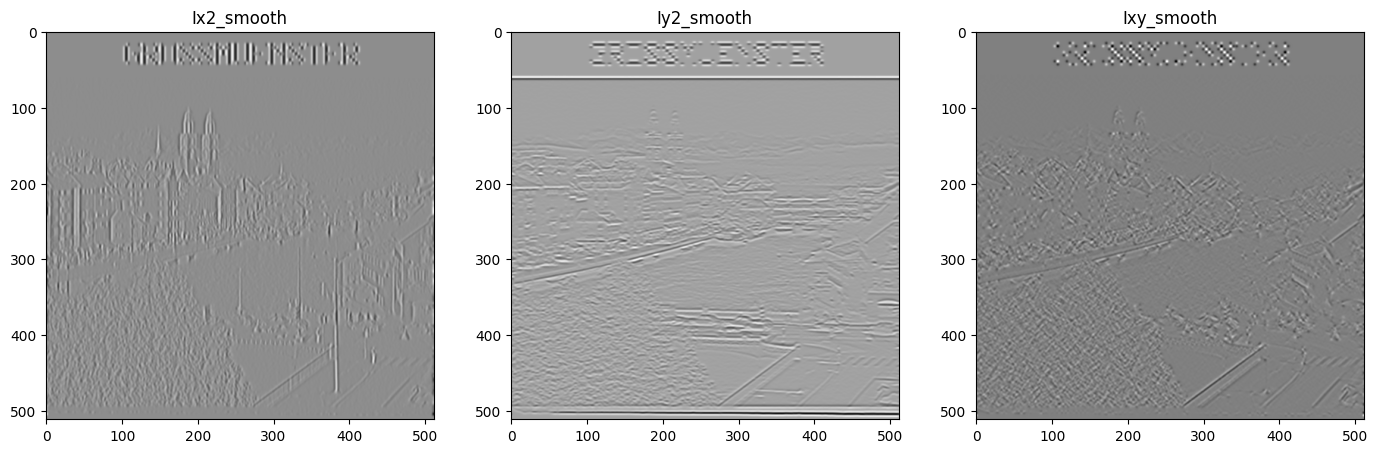

In [31]:
#Smooth version of the partial derivatives
sigma = 1
Ix2_smooth = ndimage.gaussian_filter(Ix2, sigma)
Iy2_smooth = ndimage.gaussian_filter(Iy2, sigma)
Ixy_smooth = ndimage.gaussian_filter(Ixy, sigma)

#display_image(Ix2_smooth, as_gray=True, title='Ix_smooth')
#display_image(Iy2_smooth, as_gray=True, title='Iy_smooth')
#display_image(Ixy_smooth, as_gray=True, title='Ixy_smooth')




plt.figure(figsize=(17, 8))

plt.subplot(131), plt.imshow(Ix2_smooth, cmap='gray'), plt.title('Ix2_smooth')
plt.subplot(132), plt.imshow(Iy2_smooth, cmap='gray'), plt.title('Iy2_smooth')
plt.subplot(133), plt.imshow(Ixy_smooth, cmap='gray'), plt.title('Ixy_smooth')

plt.show()

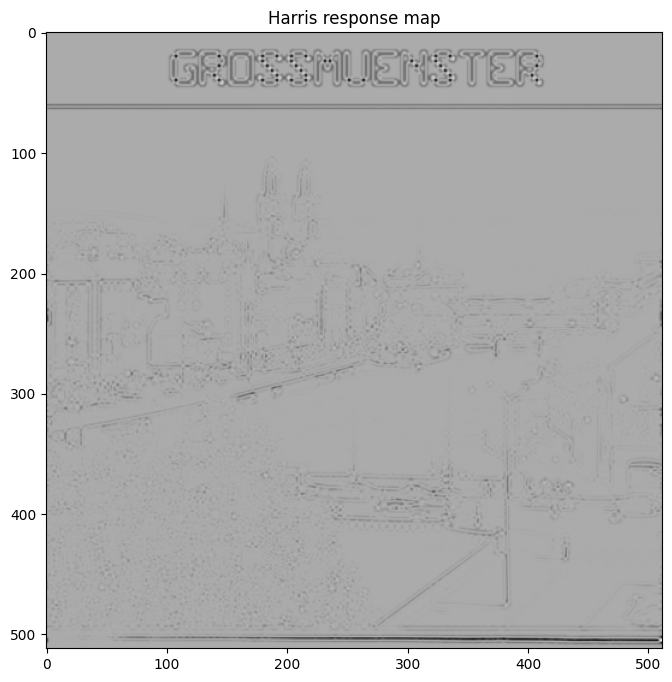

In [32]:

#Define a function for getting the autocorrelation matrix at aa given pixel (i,j)

def get_autocorr_matrix(i, j, Ix2, Iy2, Ixy):

    #Acces the values of the partial derivatives at pixel (i,j)
    Ix2_ij = Ix2[i,j]
    Iy2_ij = Iy2[i,j]
    Ixy_ij = Ixy[i,j]

    A = np.array([[Ix2_ij, Ixy_ij], [Ixy_ij, Iy2_ij]])
    return A

# Implement the Harris response function at base pixel (i,j)

def get_harris_response(i, j, Ix2, Iy2, Ixy, k=0.2):
    A = get_autocorr_matrix(i, j, Ix2, Iy2, Ixy)
    det = np.linalg.det(A)
    trace = np.trace(A)
    R = det - k * trace**2
    return R

# Compute the Harris response for all pixel
def get_harris_response_map(Ix2, Iy2, Ixy):
    height, width = Ix2.shape
    R = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            R[i,j] = get_harris_response(i, j, Ix2, Iy2, Ixy)
    return R


# Compute the Harris response map
R = get_harris_response_map(Ix2_smooth, Iy2_smooth, Ixy_smooth)



plt.figure(figsize=(17, 8))
plt.imshow(R, cmap='gray')
plt.title('Harris response map')
plt.show()

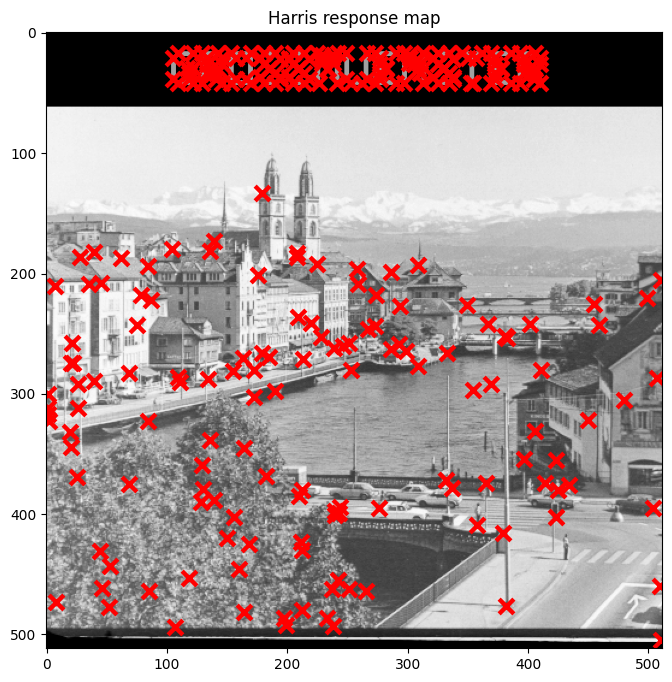

In [36]:

#Define a funciton fro checking is a pixel is a local maximum in his neightborhood of 9 pixels on an image

def is_local_maximum(i, j, R, radius=1):
    height, width = R.shape
    for k in range(-radius, radius+1):
        for l in range(-radius, radius+1):
            if (i+k) >= 0 and (i+k) < height and (j+l) >= 0 and (j+l) < width:
                if R[i,j] < R[i+k,j+l]:
                    return False
    return True

##is_local_maximum TESTING

im_test = np.zeros((10,10))
im_test[3:7, 3:7] = 1


assert is_local_maximum(3, 3, im_test, radius=1) == True
assert is_local_maximum(3, 2, im_test, radius=2) == False



#Implement non maximum suppression using is_local_maximum and a threshold theta

def non_maximum_suppression(R, theta=100000):
    height, width = R.shape
    R_nms = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            if R[i,j] > theta and is_local_maximum(i, j, R):
                R_nms[i,j] = 1#R[i,j]
    return R_nms


#Plot the result of non maximum suppression with red x markers on the original image

R_nms = non_maximum_suppression(R, theta=100000)
plt.figure(figsize=(17, 8))
plt.imshow(I, cmap='gray')
plt.scatter(np.nonzero(R_nms)[1], np.nonzero(R_nms)[0], s=5, c='r', marker='x', linewidths=15)
plt.title('Harris response map')
plt.show()


#